In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.impute import KNNImputer

#model selection from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
#ensemble
from sklearn.ensemble import RandomForestClassifier,BaggingClassifier,AdaBoostClassifier,GradientBoostingClassifier
from xgboost import XGBClassifier
#metrics
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report,confusion_matrix
#pca
from sklearn.decomposition import PCA
#data_balance
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
#warnings
import warnings
warnings.filterwarnings("ignore")

Using TensorFlow backend.


In [2]:
import os
os.chdir(r'C:\Users\VISHY\Desktop\Great Learning\Capstone\Vehicle-Loan-Default-Prediction\Data')

In [4]:
pd.set_option('display.max_rows',500)
pd.set_option('display.max_columns',500)
pd.set_option('display.width',1000)

In [3]:
df = pd.read_csv('train.csv')

df=df.drop(['UniqueID', 'branch_id','supplier_id', 'Current_pincode_ID','State_ID', 'Employee_code_ID', 'MobileNo_Avl_Flag'],axis=1)

In [4]:
def credit_risk(df):
    d1=[]
    d2=[]
    for i in df:
        p = i.split("-")
        if len(p) == 1:
            d1.append(p[0])
            d2.append('unknown')
        else:
            d1.append(p[1])
            d2.append(p[0])

    return d1,d2

risk_map = {'No Bureau History Available':-1, 
              'Not Scored: No Activity seen on the customer (Inactive)':-1,
              'Not Scored: Sufficient History Not Available':-1,
              'Not Scored: No Updates available in last 36 months':-1,
              'Not Scored: Only a Guarantor':-1,
              'Not Scored: More than 50 active Accounts found':-1,
              'Not Scored: Not Enough Info available on the customer':-1,
              'Very Low Risk':4,
              'Low Risk':3,
              'Medium Risk':2, 
              'High Risk':1,
              'Very High Risk':0}

sub_risk = {'unknown':-1, 'A':13, 'B':12, 'C':11,'D':10,'E':9,'F':8,'G':7,'H':6,'I':5,'J':4,'K':3, 'L':2,'M':1}
employment_map = {'Self employed':0, 'Salaried':1,np.nan:2}

df.loc[:,'credit_risk'],df.loc[:,'credit_risk_grade']  = credit_risk(df["PERFORM_CNS.SCORE.DESCRIPTION"])
df.loc[:,'credit_risk_label'] = df['credit_risk'].apply(lambda x: risk_map[x])
df.loc[:,'sub_risk_label'] = df['credit_risk_grade'].apply(lambda x: sub_risk[x])

df.loc[:,'employment_label'] = df['Employment.Type'].apply(lambda x: employment_map[x])

df=df.drop(['PERFORM_CNS.SCORE.DESCRIPTION', 'credit_risk', 'credit_risk_grade','Employment.Type'],axis=1)

In [5]:
df.loc[:,'no_of_accts'] = df['PRI.NO.OF.ACCTS'] + df['SEC.NO.OF.ACCTS']

df.loc[:,'pri_inactive_accts'] = df['PRI.NO.OF.ACCTS'] - df['PRI.ACTIVE.ACCTS']
df.loc[:,'sec_inactive_accts'] = df['SEC.NO.OF.ACCTS'] - df['SEC.ACTIVE.ACCTS']
df.loc[:,'tot_inactive_accts'] = df['pri_inactive_accts'] + df['sec_inactive_accts']
df.loc[:,'tot_overdue_accts'] = df['PRI.OVERDUE.ACCTS'] + df['SEC.OVERDUE.ACCTS']
df.loc[:,'tot_current_balance'] = df['PRI.CURRENT.BALANCE'] + df['SEC.CURRENT.BALANCE']
df.loc[:,'tot_sanctioned_amount'] = df['PRI.SANCTIONED.AMOUNT'] + df['SEC.SANCTIONED.AMOUNT']
df.loc[:,'tot_disbursed_amount'] = df['PRI.DISBURSED.AMOUNT'] + df['SEC.DISBURSED.AMOUNT']
df.loc[:,'tot_installment'] = df['PRIMARY.INSTAL.AMT'] + df['SEC.INSTAL.AMT']

In [6]:
def duration(dur):
    yrs = int(dur.split(' ')[0].replace('yrs',''))
    mon = int(dur.split(' ')[1].replace('mon',''))
    return yrs*12+mon

In [7]:
df['AVERAGE.ACCT.AGE'] = df['AVERAGE.ACCT.AGE'].apply(duration)
df['CREDIT.HISTORY.LENGTH'] = df['CREDIT.HISTORY.LENGTH'].apply(duration)
#df.drop(['AVERAGE.ACCT.AGE','CREDIT.HISTORY.LENGTH'],axis=1,inplace=True)

In [8]:
def age(dur):
    yr = int(dur.split('-')[2])
    if yr >=0 and yr<=19:
        return yr+2000
    else:
         return yr+1900

df['Date.of.Birth'] = df['Date.of.Birth'].apply(age)
df['DisbursalDate'] = df['DisbursalDate'].apply(age)
df['Age']=df['DisbursalDate']-df['Date.of.Birth']
df=df.drop(['DisbursalDate','Date.of.Birth'],axis=1)

In [9]:
df=df.drop(['PRI.NO.OF.ACCTS','SEC.NO.OF.ACCTS','PRI.CURRENT.BALANCE','pri_inactive_accts','sec_inactive_accts',
            'PRI.SANCTIONED.AMOUNT','SEC.NO.OF.ACCTS','PRI.NO.OF.ACCTS','PRI.DISBURSED.AMOUNT','PRI.ACTIVE.ACCTS', 
            'PRI.OVERDUE.ACCTS','SEC.CURRENT.BALANCE','SEC.SANCTIONED.AMOUNT', 'SEC.OVERDUE.ACCTS',
            'SEC.DISBURSED.AMOUNT','PRIMARY.INSTAL.AMT','SEC.INSTAL.AMT','disbursed_amount','SEC.ACTIVE.ACCTS'],axis=1)

In [10]:
nums=['asset_cost', 'ltv','PERFORM_CNS.SCORE',
       'NEW.ACCTS.IN.LAST.SIX.MONTHS', 'DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS',
       'AVERAGE.ACCT.AGE', 'CREDIT.HISTORY.LENGTH', 'NO.OF_INQUIRIES','no_of_accts', 'tot_inactive_accts',
       'tot_overdue_accts', 'tot_current_balance', 'tot_sanctioned_amount',
       'tot_disbursed_amount', 'tot_installment','Age']

In [11]:
df['Missing Features'] = (df == 0).astype(int).sum(axis=1)

In [12]:
from sklearn.preprocessing import  RobustScaler
rob_scaler = RobustScaler()

df[nums] = rob_scaler.fit_transform(df[nums])

In [13]:
y=df.loan_default
X=df.drop("loan_default",axis=1)
from sklearn.model_selection import train_test_split,KFold,cross_val_score
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [16]:
sm = SMOTE(random_state=2)
X_train, y_train = sm.fit_sample(X_train, y_train.ravel())

In [17]:
X_train.shape

(255574, 26)

In [18]:
classifiers = [
    LogisticRegression(),
    DecisionTreeClassifier(criterion='entropy',random_state=0),
    DecisionTreeClassifier(criterion='gini',random_state=0),
    RandomForestClassifier(n_estimators=100),
    GaussianNB(),
    BaggingClassifier(random_state=0),
    AdaBoostClassifier(),
    XGBClassifier(random_state=0, n_jobs=-1, learning_rate=0.2,
                  n_estimators=100, max_depth=3)
]

In [19]:
results = []
for item in classifiers:
    print(item,"\n")
    clf = item
    clf.fit(X_train, y_train)
    y_pred=clf.predict(X_test)
    #print(y_pred)
    #results.append(accuracy_score(y_test,y_pred))
    results.append(y_pred)
    print("accuracy train:",clf.score(X_train,y_train),"\n")
    print("accuracy test:",clf.score(X_test,y_test),"\n")
    print("precision :",precision_score(y_test,y_pred),"\n")
    print('Recall score:',recall_score(y_test,y_pred),'\n')
    print("f1 score:",f1_score(y_test,y_pred),"\n")
    from sklearn.metrics import classification_report
    print(classification_report(y_test,y_pred))

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False) 

accuracy train: 0.6218668565660044 

accuracy test: 0.6234863539537078 

precision : 0.3043981887746148 

Recall score: 0.5708643275623725 

f1 score: 0.3970695970695971 

              precision    recall  f1-score   support

           0       0.84      0.64      0.73     54756
           1       0.30      0.57      0.40     15191

    accuracy                           0.62     69947
   macro avg       0.57      0.60      0.56     69947
weighted avg       0.73      0.62      0.65     69947

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                

In [20]:
xgb=XGBClassifier(random_state=0, n_jobs=-1, learning_rate=0.2,
                  n_estimators=100, max_depth=3)

In [21]:
xgb.fit(X_train, y_train)
y_pred=xgb.predict(X_test)

In [37]:
print("accuracy train:",xgb.score(X_train,y_train),"\n")
print("accuracy test:",xgb.score(X_test,y_test),"\n")
print("precision :",precision_score(y_test,y_pred),"\n")
print("Recall :",recall_score(y_test,y_pred),"\n")
print("f1 score:",f1_score(y_test,y_pred),"\n")
print("Confusion Matrix \n",confusion_matrix(y_test,y_pred))

accuracy train: 0.9627818166167138 

accuracy test: 0.9553662058415657 

precision : 0.927281739007293 

Recall : 0.8620893950365348 

f1 score: 0.8934979873098178 

Confusion Matrix 
 [[53729  1027]
 [ 2095 13096]]


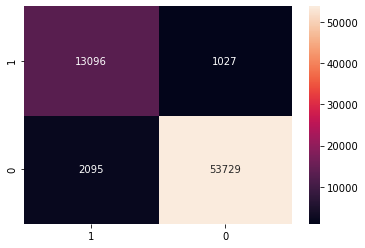

In [34]:
ax = sns.heatmap(confusion_matrix(y_test,y_pred).T,annot=True,fmt='2')
ax.invert_yaxis()
ax.invert_xaxis()

In [39]:
import sklearn.metrics as metrics

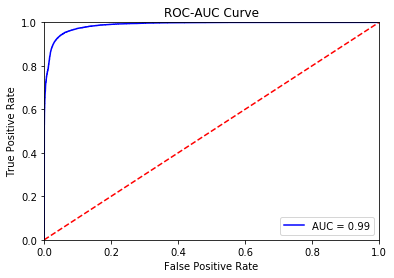

In [42]:
probs = xgb.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC-AUC Curve')
plt.show()

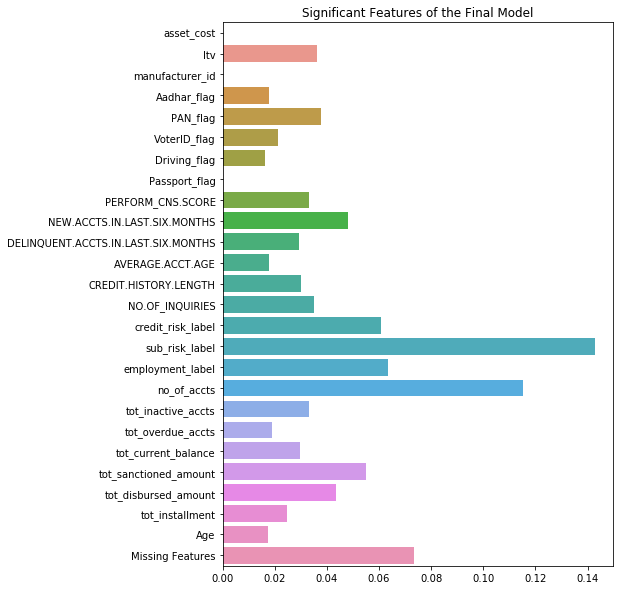

In [225]:
plt.figure(figsize=(7,10))
sns.barplot(x=xgb.feature_importances_,y=X.columns)
plt.title('Significant Features of the Final Model')
plt.show()

In [36]:
df['Missing Features'].value_counts(normalize=True)

18    0.230088
19    0.183553
9     0.097343
8     0.087054
10    0.080968
17    0.074522
11    0.055779
7     0.052167
12    0.046068
13    0.037173
6     0.020729
14    0.017285
16    0.008569
5     0.005601
15    0.002042
4     0.000982
3     0.000077
Name: Missing Features, dtype: float64

In [14]:
from sklearn.model_selection import KFold
scores=[]
for i in np.arange(1,30):
    kf = KFold(n_splits=3, shuffle=True, random_state=0)
    gb = GradientBoostingClassifier(n_estimators=i, random_state=0)
    results = cross_val_score(gb, X, y, cv=kf, scoring='roc_auc')
    scores.append(1-np.mean(results))
    print(i,1-np.mean(results))

1 0.2339855699483092
2 0.2151714051148419
3 0.16626516826352178
4 0.13535258593498412
5 0.15159705883591734
6 0.13227022674806588
7 0.13244157877696516
8 0.13219935225058965
9 0.13219935225058965
10 0.13216866737194055
11 0.1308425623619205
12 0.12806326846419935
13 0.12423153375768592
14 0.12162059077897991
15 0.11850991819600942
16 0.11543292347448564
17 0.11349192713037237
18 0.11326889580332444
19 0.1120267800994399
20 0.10869402186651167
21 0.1083264476486393
22 0.10489501838047743
23 0.10375082459465934
24 0.10171687762577764
25 0.10125371354281931
26 0.10021883050482716
27 0.09845281602218481
28 0.09637652949358222
29 0.09650500577462706


In [16]:
gb = GradientBoostingClassifier(n_estimators=28, random_state=0)
gb.fit(X_train, y_train)
y_pred=gb.predict(X_test)
print("accuracy train:",gb.score(X_train,y_train),"\n")
print("accuracy test:",gb.score(X_test,y_test),"\n")
print("precision :",precision_score(y_test,y_pred),"\n")
print("Recall :",recall_score(y_test,y_pred),"\n")
print("f1 score:",f1_score(y_test,y_pred),"\n")
print("Confusion Matrix \n",confusion_matrix(y_test,y_pred))

accuracy train: 0.8935584870746965 

accuracy test: 0.8925043247029895 

precision : 0.9426494345718901 

Recall : 0.5377526166809296 

f1 score: 0.6848304480865156 

Confusion Matrix 
 [[54259   497]
 [ 7022  8169]]
